In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time

import os

root = '../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

# Outliers

An outlier is a data point that is very different from most of the remaining data.
Hawkins formally defined the notion of an outlier as follows
> An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.

One of the most common method used to found outliers is the Tukey Fence.
This method is based on the interquartile range (IQR):

if $Q_1$ and $Q_3$ are the lower and upper quartile, an outlier is any observation outside the range:

<center> $[ Q_1 - 1.5(Q_3 - Q_1), Q_3+1.5(Q_3-Q_1) ]$ </center>

In [3]:
def time_shift(df):
    # add column to dataframe with the time distance from the previous measurement 
    
    ts = df.iloc[:,1]

    ts1 = ts[1:].values - ts[0:-1].values
    ts1 = np.concatenate([[0], ts1])
    ts1 = ts1/1000
    ts1 = ts1.round()
    
    ret = df.copy()
    ret[3] = ts1
    
    return ret

def count_outliers(df, index):
    '''
    :returtn: two dataframes
        one with the row corresponding to outliers
        one with the row corresponding to not outliers
    '''
    
    values = df.iloc[:, index].values
    Q = np.quantile(values, [.25, .75])
    Q1 = Q[0]
    Q3 = Q[1]
    IQR = Q3-Q1
    QL = Q1 - 1.5*IQR
    QH = Q3 + 1.5*IQR
    
    out_row = df[(df[index] < QL) | (df[index]>QH)]
    in_row = df[(df[index] >= QL) & (df[index] <= QH)]
    
    return in_row, out_row
    

## Values Outliers
Try to count the number of outliers on all data available

For some sensors there are no outliers count, for other there are maybe too much outliers

|Node|Type|%outliers|
|---|---|---|
|d19|temp|1.95|
|d19|sound|2.55|
|d19|light|0|
|fef|temp|0|
|fef|sound|2.4|
|fef|light|3.24|
|3bd|temp|0|
|3bd|sound|21.64|
|3bd|light|18.11|
|d1a|temp|0|
|d1a|sound|2.49|


Some data the measurements probably are not outliers, since the value can be explained by human action (like light sensor tured on). 
The method used doesn't see low variation on data (like temp 0x3bd).
Sound sensors have a lot of noisy behavior, other doesn't, in that case canno't tell whether it is a real outlier or not.

## Time sequence outliers

Considering how many measurements are outliers, in the sense that the time between two measurements is too high or to low wrt the distribution.

One problem is given by the granularity of the timestamps, it is in ms. A lot of more values will be considered outliers, also when close to 10s, so the values are rounded to the closest second

All outliers are the datapoints that are not within 10s

|Node|Type|%outliers|
|---|---|---|
|d19|temp|7.36|
|d19|sound|7.39|
|d19|light|7.39|
|fef|temp|6.8|
|fef|sound|6.79|
|fef|light|6.81|
|3bd|temp|18.08|
|3bd|sound|18.08|
|3bd|light|18.07|
|d1a|temp|6.73|
|d1a|sound|6.73|



## Count outliers in time window

Try to count the number of outliers using a sliding time window of x minutes (This can be adapted for flink)

In [4]:
def outliers_slider(df, mins=5, overlap = 0, index = 2):
    '''
    returns dataframe with point marked as outlier and not
    '''
    delta = np.timedelta64(mins,'m')
    step = delta - np.timedelta64(overlap, 'm')
        
    first_delta = df.iloc[0, 1]
    first_delta = first_delta.astype('datetime64[ms]').astype('datetime64[h]').astype('datetime64[ms]')
        
    window = []
        
    i = 0
        
    start = first_delta - step
    
    in_ret = pd.DataFrame()
    out_ret = pd.DataFrame()
    
    while i < len(df):
            
        window = []
        start = start + step
        end = start + delta
        end = end.astype('int64')
            
        while i < len(df) and df.iloc[i,1] < end:
            item = df.iloc[i,:]
            window.append(item)
            i += 1 
            
        if len(window) == 0:
            continue
                
        window_df = pd.DataFrame(window)
            
        in_window, out_window = count_outliers(window_df, index)
        
        in_ret = in_ret.append(in_window)
        out_ret = out_ret.append(out_window)
            
    return in_ret, out_ret

'''
for path in t_path+s_path+l_path:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    val_in, val_out = outliers_slider(df,2)
    ts_in, ts_out = outliers_slider(df, 3)
    
    print('val',room, st, len(val_in), len(val_out))
    print('ts',room, st, len(ts_in), len(ts_out))
    
'''
pass

|room|type|%outliers-measurements|%outliers-timesteps|
|---|---|---|---|
|0x3bd|temp|9.61|10.36|
|0x3bd|sound|9.12|9.92|
|0x3bd|light|0.37|0.46|
|0xfef|temp|2.91|3.33|
|0xfef|sound|0.36|0.4|
|0xfef|light|0.46|0.56|
|0xd19|temp|4.56|4.9|
|0xd19|sound|0.27|0.31|
|0xd19|light|0.09|0.2|
|0xd1a|temp|4.21|4.51|
|0xd1a|sound|0.79|0.76|

## Values 3bd d19

On values works quite well, but with very noisy data?

## Time sequence 3bd d19

## 3bd, d19

<IPython.core.display.Javascript object>


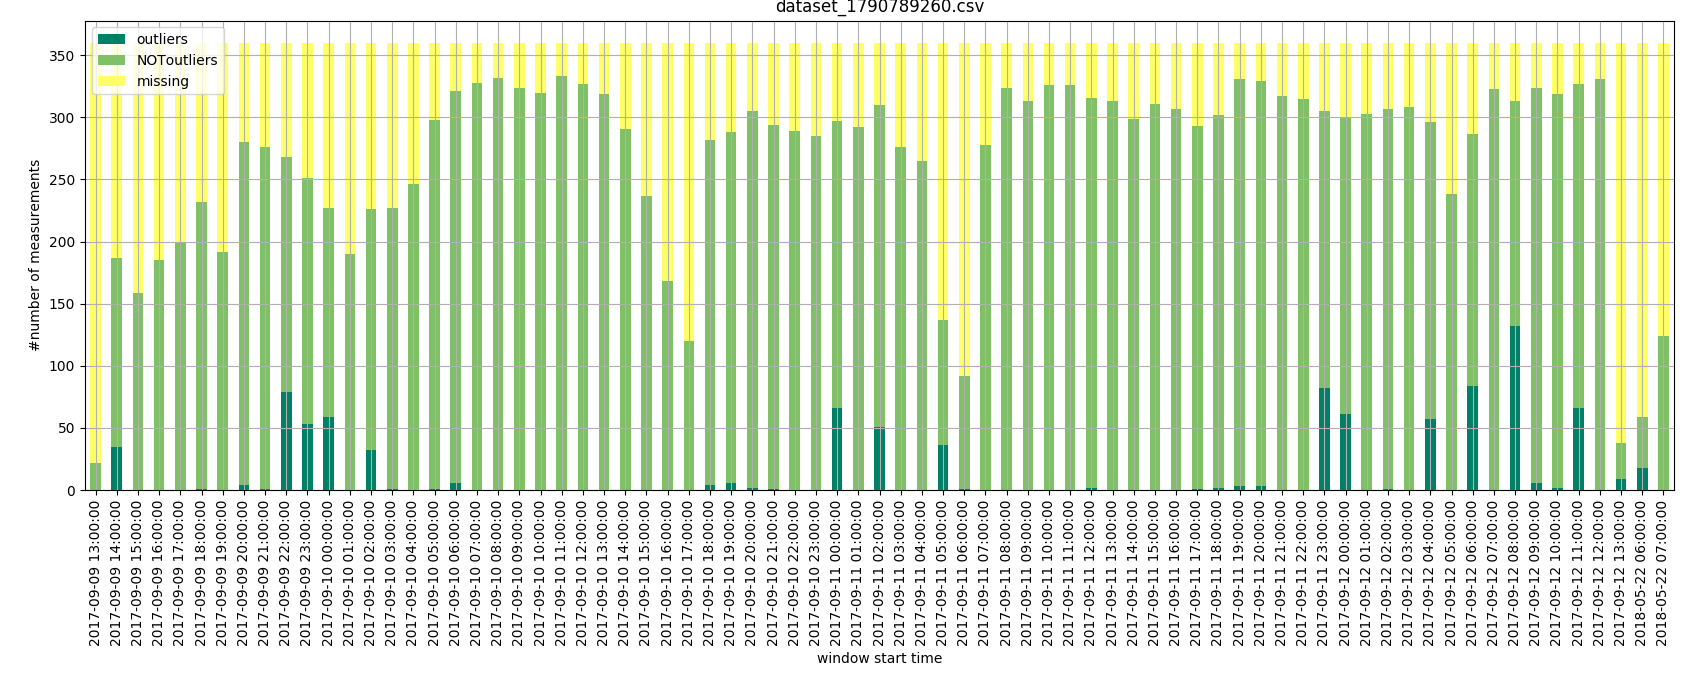

<IPython.core.display.Javascript object>


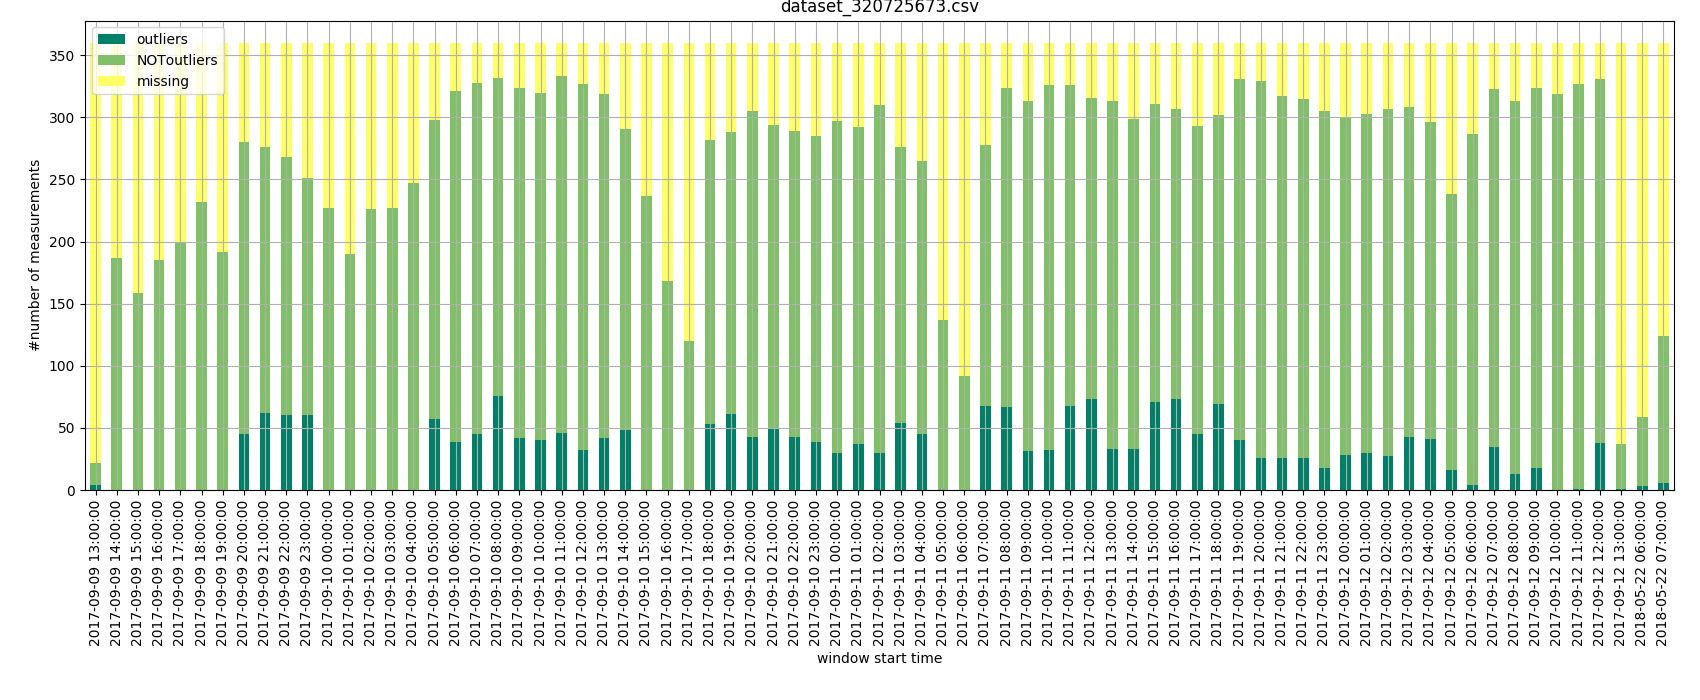

<IPython.core.display.Javascript object>


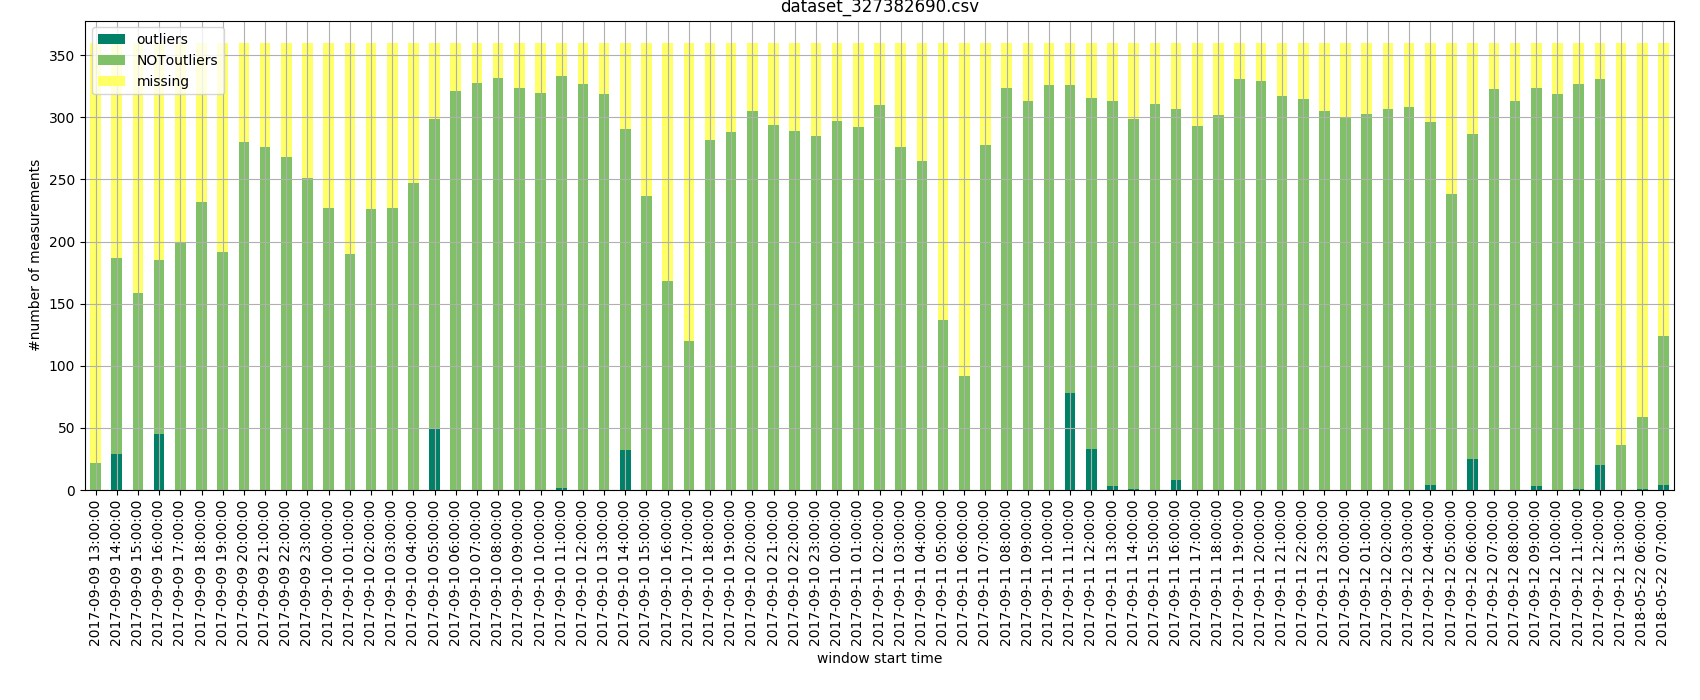

<IPython.core.display.Javascript object>


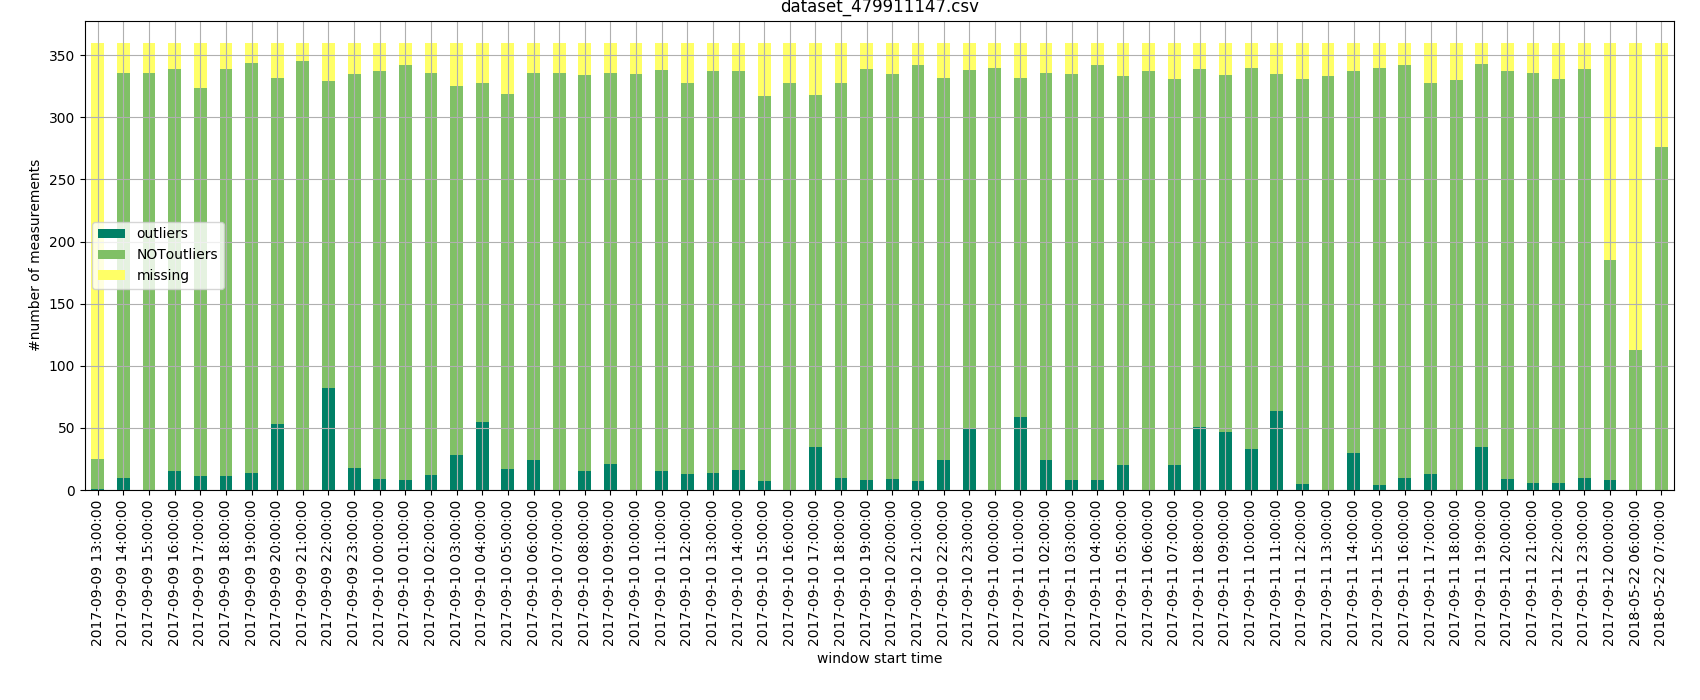

<IPython.core.display.Javascript object>


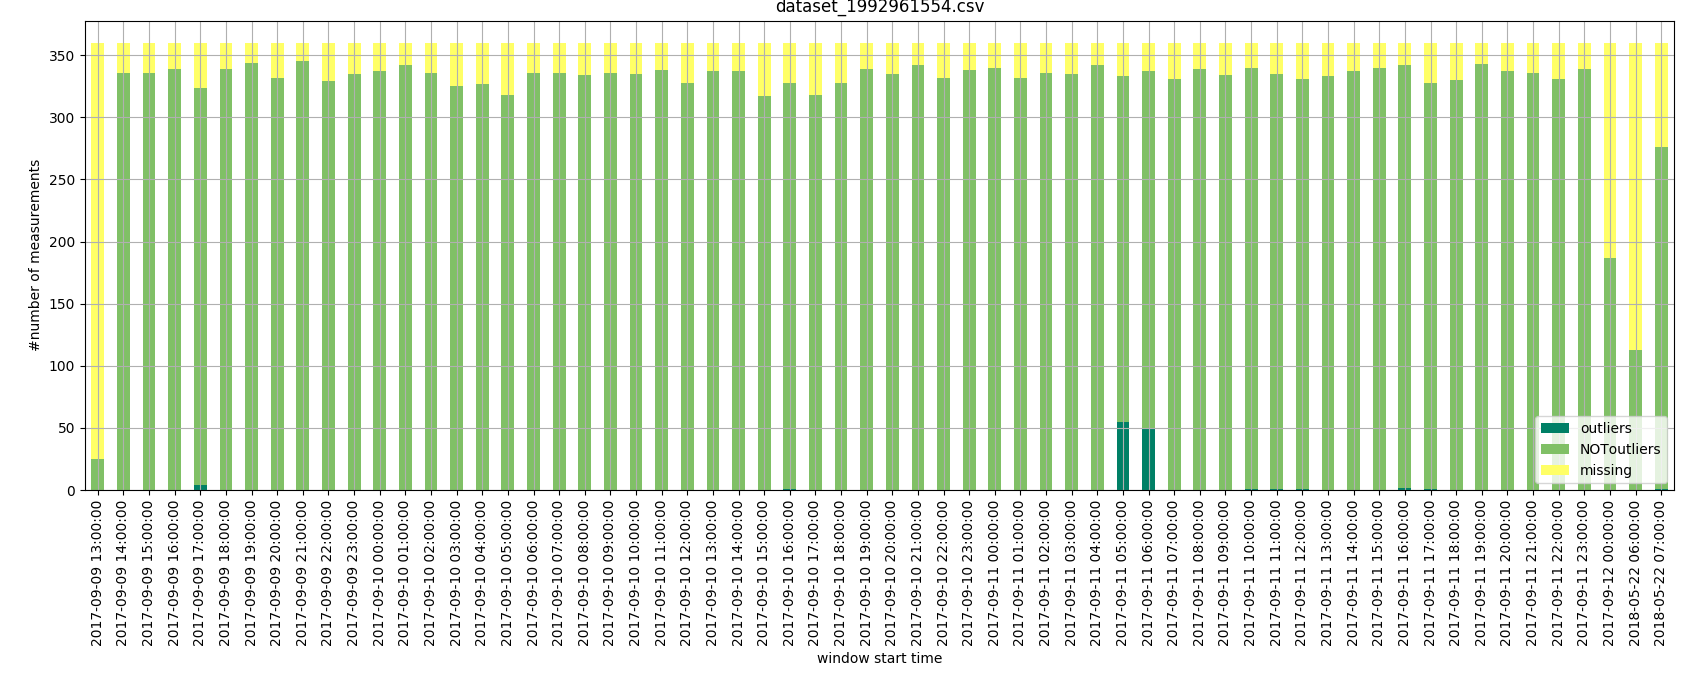

<IPython.core.display.Javascript object>


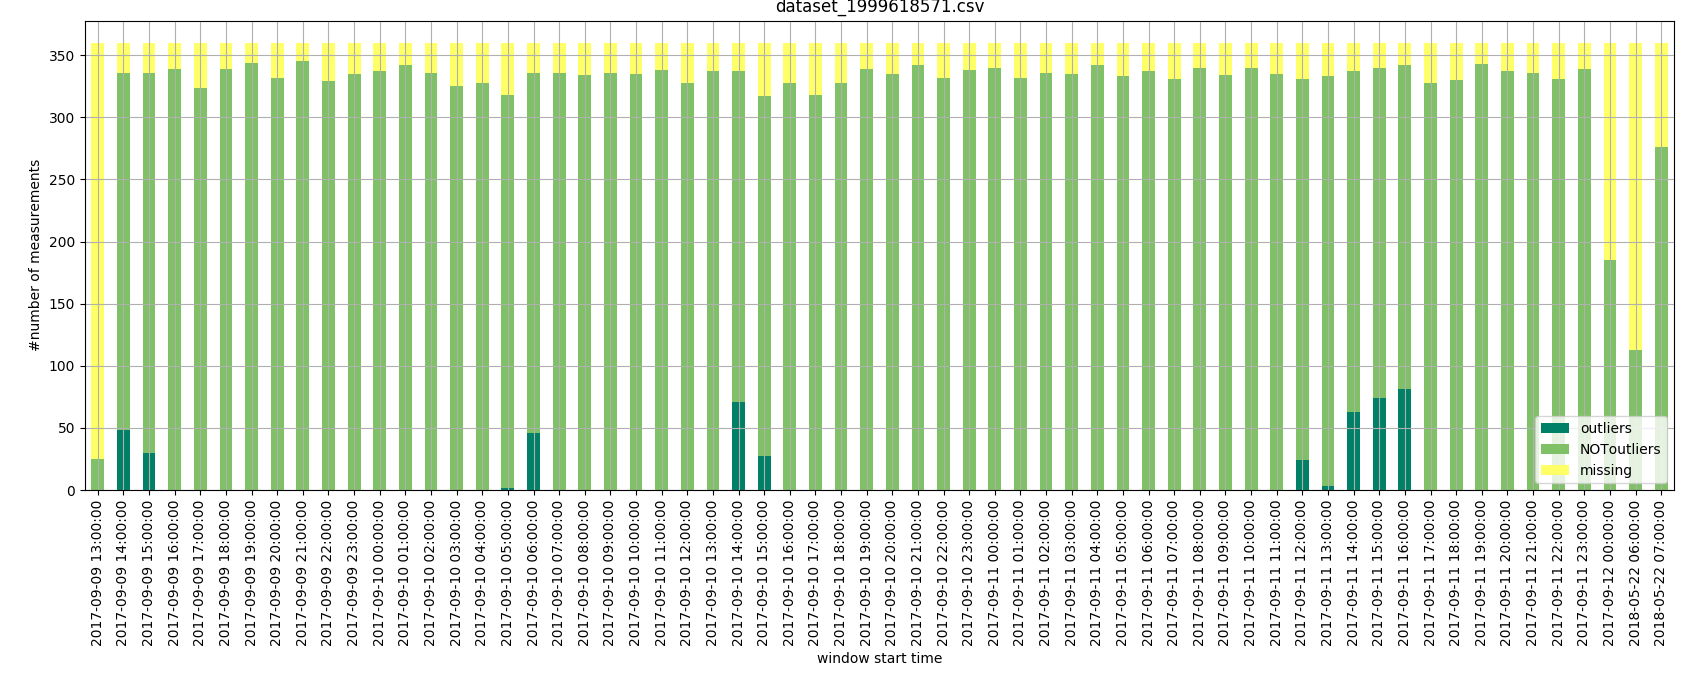

In [7]:
def time_window_slider(df, mins = 60, overlap = 0, index = 2, tr_sec = 10):
    delta = np.timedelta64(mins,'m')
    
    tr = np.timedelta64(tr_sec, 's')
    expected_num_measurements = delta / tr
        
    delta = np.timedelta64(mins,'m')
    step = delta - np.timedelta64(overlap, 'm')
    
    first_delta = df.iloc[0, 1]
    first_delta = first_delta.astype('datetime64[ms]').astype('datetime64[h]').astype('datetime64[ms]')
        
    window = []
        
    i = 0
        
    start = first_delta - step
    
    cols = ['start', 'end', 'NOToutliers', 'outliers', 'missing']    
    ret = pd.DataFrame(columns = cols)

    while i < len(df):
            
        window = []
        start = start + step
        end = start + delta
        end = end.astype('int64')
            
        while i < len(df) and df.iloc[i,1] < end:
            item = df.iloc[i,:]
            window.append(item)
            i += 1 
            
        if len(window) != 0:
                
            window_df = pd.DataFrame(window)
            in_window, out_window = count_outliers(window_df, index)
        
            in_len = len(in_window)
            out_len = len(out_window)
            missed = expected_num_measurements - (in_len + out_len)
        
        else:
            #in_len = 0
            #out_len = 0
            #missed = expected_num_measurements
            continue
        
        data = np.array([start.astype('datetime64[h]'), end.astype('datetime64[h]'), in_len, out_len, missed])
        data = data.reshape((1,-1))
                
        x = pd.DataFrame(data, columns = cols)        
        ret = ret.append(x)
                                              
    return ret

to_plot = [t_path[0], s_path[0], l_path[0]]

for temp_path in to_plot:
    path = os.path.join(root, temp_path)
    df = pd.read_csv(path, header=None)

    df_to_plot = time_window_slider(df)

    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    df_to_plot.plot(x = 0, y = [3,2,4], ax = ax, kind = 'bar', stacked = 'True', colormap = 'summer', title = temp_path)

    ax.set_xlabel('window start time')
    ax.set_ylabel('#number of measurements')
    ax.xaxis_date()
    ax.legend()
    ax.grid()

plt.show()

to_plot = [t_path[2], s_path[2], l_path[2]]

for temp_path in to_plot:
    path = os.path.join(root, temp_path)
    df = pd.read_csv(path, header=None)

    df_to_plot = time_window_slider(df)

    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    df_to_plot.plot(x = 0, y = [3,2,4], ax = ax, kind = 'bar', stacked = 'True', colormap = 'summer', title = temp_path)

    ax.set_xlabel('window start time')
    ax.set_ylabel('#number of measurements')
    ax.xaxis_date()
    ax.legend()
    ax.grid()

plt.show()

The 5 minutes windows is bad if the sensor has a very low transmission rate. 
Can solve using bigger window or throwing alert when there are too few measurements in a time window.